In [11]:
import sys
sys.path.append("../../")

In [12]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [23]:
data=pl.read_csv("preprocessed.csv")
data

symboling,aspiration_std,carbody,drivewheel_fwd,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,f64
3,1,5,0,88.6,168.8,64.1,48.8,2548,1,4,130,1,3.47,2.68,9.0,111,5000,21,27,13495.0
3,1,5,0,88.6,168.8,64.1,48.8,2548,1,4,130,1,3.47,2.68,9.0,111,5000,21,27,16500.0
1,1,1,0,94.5,171.2,65.5,52.4,2823,1,6,152,1,2.68,3.47,9.0,154,5000,19,26,16500.0
2,1,3,1,99.8,176.6,66.2,54.3,2337,1,4,109,1,3.19,3.4,10.0,102,5500,24,30,13950.0
2,1,3,1,99.4,176.6,66.4,54.3,2824,1,5,136,1,3.19,3.4,8.0,115,5500,18,22,17450.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-1,1,3,0,109.1,188.8,68.9,55.5,2952,1,4,141,1,3.78,3.15,9.5,114,5400,23,28,16845.0
-1,0,3,0,109.1,188.8,68.8,55.5,3049,1,4,141,1,3.78,3.15,8.7,160,5300,19,25,19045.0
-1,1,3,0,109.1,188.8,68.9,55.5,3012,1,6,173,1,3.58,2.87,8.8,134,5500,18,23,21485.0


# Previous raw results

Test Scores: [0.49117655 0.84072664 0.84359816]
Training Scores: [0.91711393 0.9031102  0.89930425]
Mean Test Score: 0.7251671177839505
Standard Deviation of Test Scores: 0.16546046773001982
Mean absolute Error: 4182.798902713215
R-squared: 0.4633797777209826


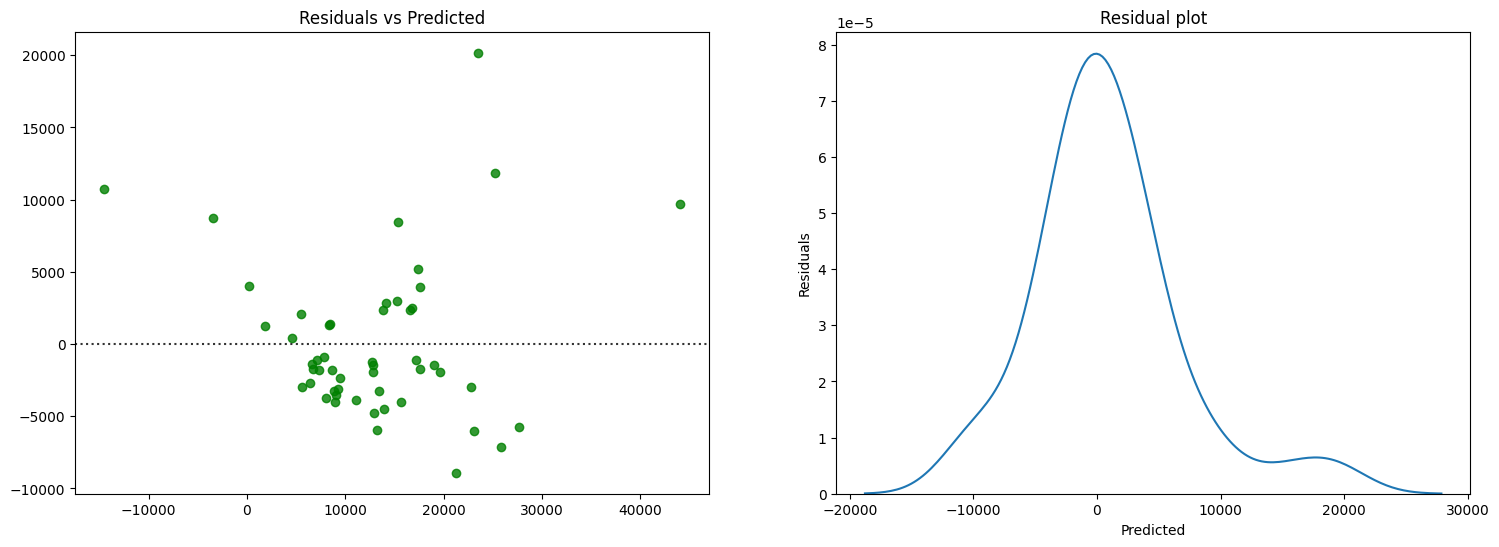

In [24]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data["price"],test_size=0.25,random_state=0)
lr=LinearRegression()

kf=KFold(n_splits=3)
cv_results = cross_validate(lr, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score

predictions = cross_val_predict(lr, X_test, y_test, cv=kf)
residuals = y_test - predictions
mse = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Residuals range is huge from -10k to 20K == 30k width

### R2 score 46 and mean_absolute_error 4182

<AxesSubplot: >

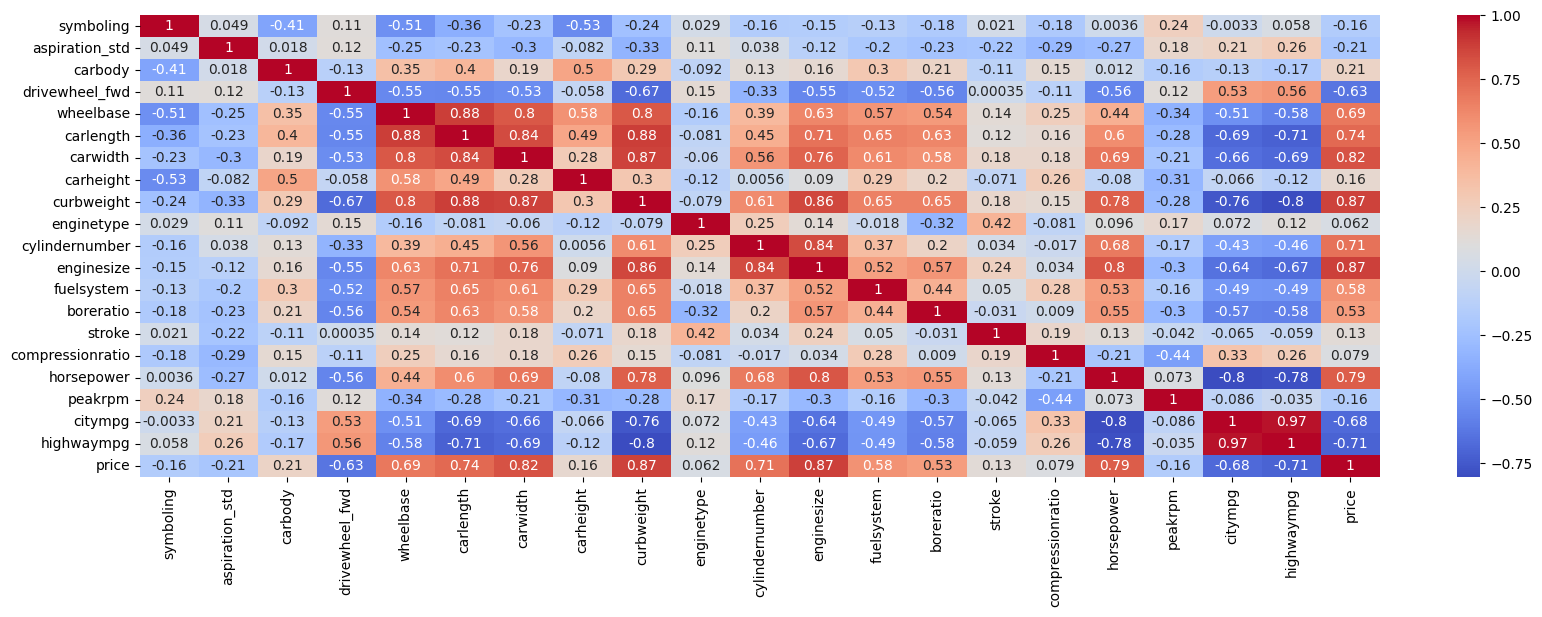

In [15]:
plt.figure(figsize=(20,6))
sns.heatmap(data.to_pandas().corr(),annot=True,cmap="coolwarm")

# Manual Feature Selection based on correlations

Dropping multicollinear features

In [16]:
data=data.drop(["compressionratio","citympg","highwaympg","carlength","wheelbase"])

Dropping Based on variance inflation factor

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(data.drop("price").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,5048.993462
10,enginesize,23.185320
7,curbweight,15.731842
9,cylindernumber,10.784932
14,horsepower,8.165036


In [18]:
data=data.drop("enginesize")
df = sm.add_constant(data.drop("price").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,4755.675844
7,curbweight,11.829268
13,horsepower,8.137884
5,carwidth,4.824682
9,cylindernumber,4.437382


Test Scores: [0.80815204 0.81413605 0.8521049 ]
Training Scores: [0.88168878 0.8911004  0.8704501 ]
Mean Test Score: 0.8247976637188236
Standard Deviation of Test Scores: 0.01946306164388429
Mean absolute Error: 3250.9280148265843
R-squared: 0.6459671424158319


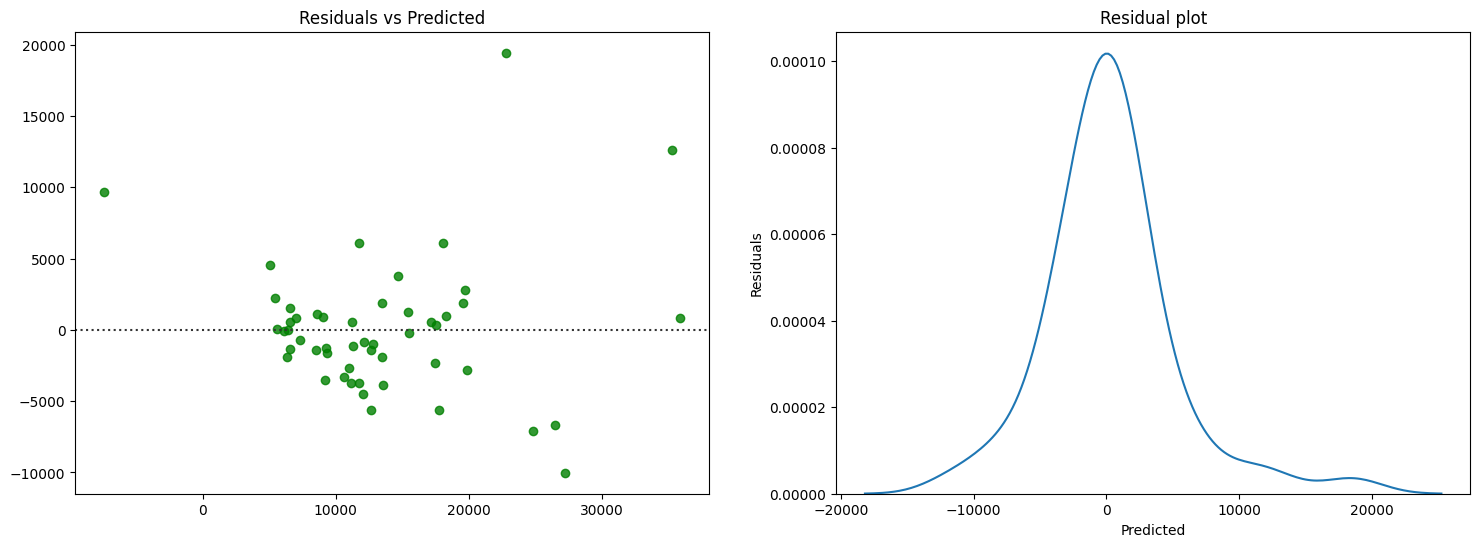

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data["price"],test_size=0.25,random_state=0)
lr=LinearRegression()

kf=KFold(n_splits=3)
cv_results = cross_validate(lr, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score

predictions = cross_val_predict(lr, X_test, y_test, cv=5)
residuals = y_test - predictions
mse = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# mean test score changed from 72 to 82

### Not much change in residual range

### R2 score increased from 46 to 64 and mean_absolute_error descreased from 4182 to 3250

Residuals roughly following normal

Standardizing the features

In [20]:
df.describe()

,const,symboling,aspiration_std,carbody,drivewheel_fwd,carwidth,carheight,curbweight,enginetype,cylindernumber,fuelsystem,boreratio,stroke,horsepower,peakrpm
count,202.0,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,1.0,0.801980,0.816832,2.450495,0.638614,65.921287,53.756436,2552.371287,0.861386,4.356436,0.549505,3.323663,3.260693,102.589109,5113.613861
std,0.0,1.225921,0.387765,1.159012,0.481596,2.158264,2.447759,523.876904,0.346402,1.070492,0.498779,0.268145,0.312886,37.772354,470.973702
min,1.0,-2.000000,0.000000,1.000000,0.000000,60.300000,47.800000,1488.000000,0.000000,2.000000,0.000000,2.540000,2.070000,48.000000,4150.000000
25%,1.0,0.000000,1.000000,1.000000,0.000000,64.025000,52.000000,2145.000000,1.000000,4.000000,0.000000,3.150000,3.112500,70.000000,4800.000000
50%,1.0,1.000000,1.000000,3.000000,1.000000,65.500000,54.100000,2412.000000,1.000000,4.000000,1.000000,3.310000,3.290000,95.000000,5150.000000
75%,1.0,2.000000,1.000000,3.000000,1.000000,66.900000,55.500000,2947.750000,1.000000,4.000000,1.000000,3.580000,3.410000,116.000000,5500.000000
max,1.0,3.000000,1.000000,5.000000,1.000000,72.300000,59.800000,4066.000000,1.000000,12.000000,1.000000,3.940000,4.170000,288.000000,6600.000000


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

Test Scores: [0.80815204 0.81413605 0.8521049 ]
Training Scores: [0.88168878 0.8911004  0.8704501 ]
Mean Test Score: 0.8247976637188241
Standard Deviation of Test Scores: 0.019463061643884984
Mean absolute Error: 3250.9280148265843
R-squared: 0.6459671424158319


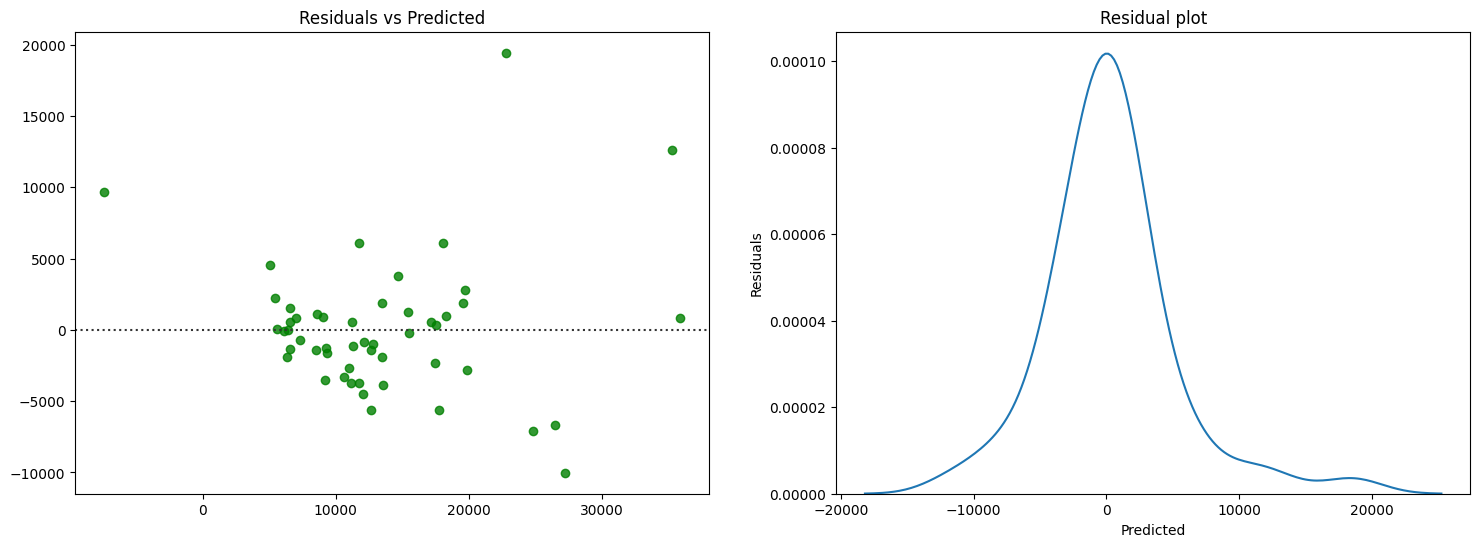

In [22]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data["price"],test_size=0.25,random_state=0)

kf=KFold(n_splits=3)
cv_results = cross_validate(pipe, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score

predictions = cross_val_predict(lr, X_test, y_test, cv=5)
residuals = y_test - predictions
mse = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# no change after Standardizing